In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import scipy.cluster.hierarchy as sch

# Creating Shuffled Video

## Pre Processing
- Drop frames which have less than 2 features

In [2]:
# Read the original video
original_video = cv2.VideoCapture('video/original.mp4')

# Get the video properties
fps = original_video.get(cv2.CAP_PROP_FPS)
frame_width = int(original_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(original_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize an array to store the frames
frames = []
# Initialize feature detector
orb = cv2.ORB_create()

# Loop through the frames of the original video
while True:
    # Read a frame from the video
    ret, frame = original_video.read()
    # Break the loop if the video has ended
    if not ret:
        break
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detect and compute the ORB features
    keypoints, descriptors = orb.detectAndCompute(gray_frame, None)
    # Drop the frame if it has less than 2 features
    if len(keypoints) < 2:
        continue
    # Add the frame  to the array
    frames.append(frame)

# Release the video object
original_video.release()


# Define the output video path
output_path = 'video/orginal_processed.mp4'

# Create a VideoWriter object to save the new video
output_video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height), isColor=True)

# Write each frame to the output video
for frame_with_features in frames:
    output_video.write(frame_with_features)

# Release the video object
output_video.release()

print(f"The new video has been saved as '{output_path}'.")


The new video has been saved as 'video/orginal_processed.mp4'.


## Shuffle and Store the orginal order for error analysis.

In [3]:
orginal_order = list(range(0, len(frames)))

# Shuffle frames, except first and last
first_frame = frames[0:5]
last_frame = frames[-5:]
orginal_order_first = orginal_order[0:5]
orginal_order_last = orginal_order[-5:]

frames = frames[5:-5]
orginal_order = orginal_order[5:-5]

random.Random(10).shuffle(frames)
random.Random(10).shuffle(orginal_order)

frames = first_frame + frames + last_frame
orginal_order = orginal_order_first + orginal_order + orginal_order_last


# UNCOMMENT THIS IF YOU WANT TO IGNORE THE SHUFFLING OF FIRST AND LAST FRAMES. MAKE SURE TO DELETE BEFORE
# # Saving the orginal order of frames for error analysis
# orginal_order = list(range(0, len(frames)))
# random.Random(4).shuffle(frames)
# random.Random(4).shuffle(orginal_order)
# print(orginal_order[:10])


## Save shuffled video.

In [4]:
# Define the output video path
output_path = 'video/shuffled.mp4'

# Create a VideoWriter object to save the shuffled video
output_video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height), isColor=True)

# Write each frame to the output video
for frame in frames:
    output_video.write(frame)

# Release the video object
output_video.release()

print(f"The shuffled video has been saved as '{output_path}'.")

The shuffled video has been saved as 'video/shuffled.mp4'.


---
# Preprocessing

## Read shuffled video.
- greyscale the frames
- downsample the frames

In [5]:
# Read the shuffled video
shuffled_video = cv2.VideoCapture('video/shuffled.mp4')

# Initialize an array to store the frames
shuffled_frames = []

# Loop through the frames of the shuffled video
while True:
    # Read a frame from the video
    ret, frame = shuffled_video.read()
    # Break the loop if the video has ended
    if not ret:
        break
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Downsample the frame
    downsampled_frame = cv2.resize(gray_frame, (0, 0), fx=0.5, fy=0.5)
    # Add the frame to the array
    shuffled_frames.append(downsampled_frame)

# Release the video object
shuffled_video.release()

# Print the number of frames
print(f"The shuffled video contains {len(shuffled_frames)} frames.")

The shuffled video contains 297 frames.


## ORB features for all frames

In [6]:

# extract ORB features from all frames and store them in a list
orb = cv2.ORB_create()
descriptors = []
for frame in shuffled_frames:
    keypoints, descriptor = orb.detectAndCompute(frame, None)
    descriptors.append(descriptor)


## Compute Cost Matrix
- Number of matches
- L1 Distance between matched features
- L2 Distance between matched features

In [7]:
# match features between frames
match_map = np.zeros((len(frames), len(frames))) - 1
distance_l1_map = np.zeros((len(frames), len(frames))) - 1
distance_l2_map = np.zeros((len(frames), len(frames))) - 1

# match features between frames
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(len(frames)):
    for j in range(i+1, len(frames)):
        if match_map[i, j] == -1:
            
            matches = bf.match(descriptors[i], descriptors[j])
            # Number of Matches
            num_matches = len(matches)
            match_map[i, j] = num_matches
            match_map[j, i] = num_matches
            # Distance Matches
            distance_l1 = 0
            distance_l2 = 0
            for match in matches:
                distance_l1 += match.distance
                distance_l2 += match.distance ** 2
            distance_l1_map[i, j] = distance_l1 / num_matches
            distance_l1_map[j, i] = distance_l1 / num_matches
            distance_l2_map[i, j] = distance_l2 / num_matches
            distance_l2_map[j, i] = distance_l2 / num_matches

print(match_map[:10, :10])

[[ -1. 400. 387. 397. 393. 284. 285. 318. 342. 300.]
 [400.  -1. 415. 419. 416. 282. 320. 320. 340. 315.]
 [387. 415.  -1. 458. 454. 305. 316. 322. 347. 312.]
 [397. 419. 458.  -1. 455. 300. 315. 326. 364. 311.]
 [393. 416. 454. 455.  -1. 298. 309. 335. 361. 312.]
 [284. 282. 305. 300. 298.  -1. 270. 282. 286. 382.]
 [285. 320. 316. 315. 309. 270.  -1. 267. 287. 277.]
 [318. 320. 322. 326. 335. 282. 267.  -1. 332. 300.]
 [342. 340. 347. 364. 361. 286. 287. 332.  -1. 300.]
 [300. 315. 312. 311. 312. 382. 277. 300. 300.  -1.]]


## Processing the distance maps
Ideally, if we take number of matches as a paramenter, we should always maximize the number of matches but, if we take distance as a parameter, we should minimize the distance.
In order to simplify our work, we will invert the distance matrix with the same scale so we can use the same algorithms for all of them.

In [8]:
max_distance_l1 = np.max(distance_l1_map)
distance_l1_map = distance_l1_map * -1
distance_l1_map += max_distance_l1
np.fill_diagonal(distance_l1_map, -1)

max_distance_l2 = np.max(distance_l2_map)
distance_l2_map = distance_l2_map * -1
distance_l2_map += max_distance_l2
np.fill_diagonal(distance_l2_map, -1)

---
# Sorting Algorithm


## Growth alogrithm (Merge Sort Based)
we start with a random frame, finding the nearest neighbor frame based on cost. This frame is appended to the sequence depending on its proximity to the start or end. The process repeats until all frames are sorted.

In [9]:
def reorder_frames_and_save_video(cost_matrix, orginal_order_growth, shuffled_video_path, output_video_path):
    # Initialize list to store reordered frames
    reordered_frames = []
    matches_list = cost_matrix
    num_frames = len(matches_list)
    # Start with the first frame
    current_frame = 0
    reordered_frames.append(current_frame)
    # Find the frame with the highest number of feature matches
    next_frame = np.argmax(matches_list[current_frame])
    reordered_frames.append(next_frame)
    # Update current frame
    current_frame = reordered_frames[-1]

    # Repeat until all frames have been added to reordered_frames
    while len(reordered_frames) < num_frames:
        # Split remaining frames into two groups
        remaining_frames = [i for i in range(num_frames) if i not in reordered_frames]
        # find the frame with the highest number of feature matches with current frame
        next_frame = remaining_frames[np.argmax([matches_list[current_frame][i] for i in remaining_frames])]

        # compare number of matches of next frame with current frame and number of matches of next frame with first frame
        if matches_list[current_frame][next_frame] > matches_list[reordered_frames[0]][next_frame]:
            reordered_frames.insert(0, next_frame)
        else:
            reordered_frames.append(next_frame)

        current_frame = reordered_frames[-1]
    print(f"Number of frames reordered: {len(reordered_frames)}")
    print("All frames have been reordered.")
    ordered_orginal_order_growth = [orginal_order_growth[i] for i in reordered_frames]

    # Read the shuffled video
    shuffled_video = cv2.VideoCapture(shuffled_video_path)

    # Get the video properties
    fps = shuffled_video.get(cv2.CAP_PROP_FPS)
    frame_width = int(shuffled_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(shuffled_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a VideoWriter object to save the reordered video
    output_video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height), isColor=True)

    # Write each reordered frame to the output video
    for frame_index in reordered_frames:
        # Set the current frame position in the shuffled video
        shuffled_video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

        # Read the current frame from the shuffled video
        ret, frame = shuffled_video.read()

        # Write the current frame to the output video
        output_video.write(frame)

    # Release the video objects
    shuffled_video.release()
    output_video.release()

    print(f"The reordered video has been saved as '{output_video_path}'.")
    return ordered_orginal_order_growth


## Travelling Salesman Problem
On Close observation we can map our original problem of sorting a video, to a variant of the Travelling Salesman Problem. Using the Travelling Salesman Problem (TSP) approach to sort frames in video sorting involves modeling the sequence of frames as a fully connected graph. Each frame represents a node, and the edges between them are weighted according to the cost of transitioning from one frame to another, as defined in a cost matrix. The goal is to find the shortest path that visits each frame once, creating an optimal sequence. This approach, especially when employing a greedy algorithm, efficiently organizes frames in a manner that minimizes the overall transition cost, thus ensuring a smooth and logical progression of the video content. Unlike the traditional TSP, this variant does not require returning to the starting frame, making it more suitable for linear video sequences. 

In [10]:
import numpy as np
import cv2

def create_tsp_ordered_video(matches_map, original_video_path, orginal_order, output_video_path, isColor=True):
    def order_sequence_with_max_match(matches_map):
        N = len(matches_map) - 1  # Assuming matches_map is square
        sequence = [0]
        visited = {0, N}  # Start and end are already visited

        current = 0
        while len(sequence) < N:
            next_element = np.argmax([matches_map[current][j] if j not in visited else -np.inf for j in range(N + 1)])
            sequence.append(next_element)
            visited.add(next_element)
            current = next_element

        sequence.append(N)
        return sequence

    # Order the frames based on the matches_map
    sequence = order_sequence_with_max_match(matches_map)


    # Read the original video
    original_video = cv2.VideoCapture(original_video_path)

    # Get the video properties
    fps = original_video.get(cv2.CAP_PROP_FPS)
    frame_width = int(original_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(original_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a VideoWriter object to save the new video
    output_video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height), isColor=isColor)

    # Write each frame from the ordered sequence to the output video
    for index in sequence:
        original_video.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = original_video.read()
        if ret:
            output_video.write(frame)

    # Release the video objects
    original_video.release()
    output_video.release()

    # Order the orginal_order sequence
    ordered_orginal_order = [orginal_order[i] for i in sequence]
    # print("Ordered orginal_order sequence:", ordered_orginal_order[20:30])

    return ordered_orginal_order, sequence



## Hierarchial clustering
This is a method where each frame is initially treated as a separate cluster. The algorithm then progressively merges these clusters based on similarity measures, often derived from a predefined cost matrix. This approach organizes the video frames into a hierarchy, from individual frames to increasingly larger clusters, until a single, sorted sequence is achieved. This method is particularly useful for sorting video frames in a way that reflects their natural continuity and progression, making it an effective tool in video sorting.

In [11]:
def create_hierarchically_ordered_video(cost_matrix, original_video_path, orginal_order, output_video_path, isColor=True):
    
    max_cost = np.max(cost_matrix)
    cost_matrix = cost_matrix * -1
    cost_matrix += max_cost
    np.fill_diagonal(cost_matrix, 0)


    # Perform hierarchical clustering
    Z = sch.linkage(sch.distance.squareform(cost_matrix), method='average')
    order = sch.leaves_list(Z)
    # print("The order of frames is:", order)

    # Read the original video
    original_video = cv2.VideoCapture(original_video_path)

    # Get the video properties
    fps = original_video.get(cv2.CAP_PROP_FPS)
    frame_width = int(original_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(original_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a VideoWriter object to save the new video
    output_video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height), isColor=isColor)

    # Write each frame from the ordered sequence to the output video
    for index in order:
        original_video.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = original_video.read()
        if ret:
            output_video.write(frame)

    # Release the video objects
    original_video.release()
    output_video.release()

    # Order the orginal_order sequence
    ordered_orginal_order = [orginal_order[i] for i in order]
    # print("Ordered orginal_order sequence:", ordered_orginal_order[20:30])

    return ordered_orginal_order, order



## Running for Diffrent Parameters
### Number of Matches

In [12]:
cost_matrix = match_map.copy()
orginal_order_growth_match = orginal_order.copy()
shuffled_video_path = 'video/shuffled.mp4'
output_video_path = 'video/number_of_matches/reordered_grow_matches.mp4'
sequence_growth_match = reorder_frames_and_save_video(cost_matrix, orginal_order_growth_match, shuffled_video_path, output_video_path)

Number of frames reordered: 297


All frames have been reordered.
The reordered video has been saved as 'video/number_of_matches/reordered_grow_matches.mp4'.


In [13]:

original_video_path = 'video/shuffled.mp4'
output_video_path = 'video/number_of_matches/reordered_hier_matches.mp4'
orginal_order_hier_match = orginal_order.copy()
cost_matrix = match_map.copy()
sequence_hier_match, order = create_hierarchically_ordered_video(cost_matrix, original_video_path, orginal_order_hier_match, output_video_path)
print("The ordered video has been saved as:", output_video_path)

The ordered video has been saved as: video/number_of_matches/reordered_hier_matches.mp4


In [14]:
original_video_path = 'video/shuffled.mp4'
output_video_path = 'video/number_of_matches/reordered_tsp_matches.mp4'
orginal_order_tsp_match = orginal_order.copy()
cost_matrix = match_map.copy()
sequence_tsp_match, sequence = create_tsp_ordered_video(cost_matrix, original_video_path, orginal_order_tsp_match, output_video_path)
print("The ordered video has been saved as:", output_video_path)

The ordered video has been saved as: video/number_of_matches/reordered_tsp_matches.mp4


### L1 Distance

In [15]:
cost_matrix = distance_l1_map.copy()
orginal_order_growth_l1_distance = orginal_order.copy()
shuffled_video_path = 'video/shuffled.mp4'
output_video_path = 'video/l1_distance/reordered_grow_l1_distance.mp4'
sequence_growth_l1 = reorder_frames_and_save_video(cost_matrix, orginal_order_growth_l1_distance, shuffled_video_path, output_video_path)

Number of frames reordered: 297
All frames have been reordered.
The reordered video has been saved as 'video/l1_distance/reordered_grow_l1_distance.mp4'.


In [16]:
cost_matrix = distance_l1_map.copy()
original_video_path = 'video/shuffled.mp4'
output_video_path = 'video/l1_distance/reordered_hier_l1_distance.mp4'
orginal_order_hier_l1_distance = orginal_order.copy()
sequence_hier_l1, order = create_hierarchically_ordered_video(cost_matrix, original_video_path, orginal_order_hier_l1_distance, output_video_path)
print("The ordered video has been saved as:", output_video_path)

The ordered video has been saved as: video/l1_distance/reordered_hier_l1_distance.mp4


In [17]:
original_video_path = 'video/shuffled.mp4'
output_video_path = 'video/l1_distance/reordered_tsp_l1_distance.mp4'
orginal_order_tsp_l1_distance = orginal_order.copy()
cost_matrix = distance_l1_map.copy()
sequence_tsp_l1, sequence = create_tsp_ordered_video(cost_matrix, original_video_path, orginal_order_tsp_l1_distance, output_video_path)
print("The ordered video has been saved as:", output_video_path)

The ordered video has been saved as: video/l1_distance/reordered_tsp_l1_distance.mp4


### L2 Distance

In [18]:
cost_matrix = distance_l2_map.copy()
orginal_order_growth_l2_distance = orginal_order.copy()
shuffled_video_path = 'video/shuffled.mp4'
output_video_path = 'video/l2_distance/reordered_grow_l2_distance.mp4'
sequence_growth_l2 = reorder_frames_and_save_video(cost_matrix, orginal_order_growth_l2_distance, shuffled_video_path, output_video_path)

Number of frames reordered: 297
All frames have been reordered.
The reordered video has been saved as 'video/l2_distance/reordered_grow_l2_distance.mp4'.


In [19]:
cost_matrix = distance_l2_map.copy()
original_video_path = 'video/shuffled.mp4'
output_video_path = 'video/l2_distance/reordered_hier_l2_distance.mp4'
orginal_order_hier_l2_distance = orginal_order.copy()
sequence_hier_l2, order = create_hierarchically_ordered_video(cost_matrix, original_video_path, orginal_order_hier_l2_distance, output_video_path)
print("The ordered video has been saved as:", output_video_path)

The ordered video has been saved as: video/l2_distance/reordered_hier_l2_distance.mp4


In [20]:
original_video_path = 'video/shuffled.mp4'
output_video_path = 'video/l2_distance/reordered_tsp_l2_distance.mp4'
orginal_order_tsp_l2_distance = orginal_order.copy()
cost_matrix = distance_l2_map.copy()
sequence_tsp_l2, sequence = create_tsp_ordered_video(cost_matrix, original_video_path, orginal_order_tsp_l2_distance, output_video_path)
print("The ordered video has been saved as:", output_video_path)

The ordered video has been saved as: video/l2_distance/reordered_tsp_l2_distance.mp4


---
# Performance Metrics


## Lograthmic error function
This is implemented as suggested by the Paper.

In [21]:
# Paper Error Function
def calculate_sum_error(reord, x0=10):
    # Calculate the absolute difference between consecutive elements of reord
    diff = np.abs(reord[1:] - reord[:-1])

    # Calculate the exponential term
    exp_term = np.exp(-0.5 * (diff - x0))

    # Calculate the denominator term
    denominator = 1 + exp_term

    # Calculate the sum of the error
    sum_error = np.sum(1 / denominator) / len(reord)

    return sum_error

In [22]:
error_orginal = calculate_sum_error(np.array(list(range(0, len(frames)))))
print(f"The error of the orginal video is {error_orginal:.2f}.")
error_shuffled = calculate_sum_error(np.array(orginal_order))
print(f"The error of the shuffled video is {error_shuffled:.2f}.")
error_growth_match = calculate_sum_error(np.array(sequence_growth_match))
print(f"The error of the growth_match video is {error_growth_match:.2f}.")
error_hier_match = calculate_sum_error(np.array(sequence_hier_match))
print(f"The error of the hier_match video is {error_hier_match:.2f}.")
error_tsp_match = calculate_sum_error(np.array(sequence_tsp_match))
print(f"The error of the tsp_match video is {error_tsp_match:.2f}.")
error_growth_l1 = calculate_sum_error(np.array(sequence_growth_l1))
print(f"The error of the growth_l1 video is {error_growth_l1:.2f}.")
error_hier_l1 = calculate_sum_error(np.array(sequence_hier_l1))
print(f"The error of the hier_l1 video is {error_hier_l1:.2f}.")
error_tsp_l1 = calculate_sum_error(np.array(sequence_tsp_l1))
print(f"The error of the tsp_l1 video is {error_tsp_l1:.2f}.")
error_growth_l2 = calculate_sum_error(np.array(sequence_growth_l2))
print(f"The error of the growth_l2 video is {error_growth_l2:.2f}.")
error_hier_l2 = calculate_sum_error(np.array(sequence_hier_l2))
print(f"The error of the hier_l2 video is {error_hier_l2:.2f}.")
error_tsp_l2 = calculate_sum_error(np.array(sequence_tsp_l2))
print(f"The error of the tsp_l2 video is {error_tsp_l2:.2f}.")

The error of the orginal video is 0.01.
The error of the shuffled video is 0.91.
The error of the growth_match video is 0.20.
The error of the hier_match video is 0.20.
The error of the tsp_match video is 0.11.
The error of the growth_l1 video is 0.24.
The error of the hier_l1 video is 0.15.
The error of the tsp_l1 video is 0.10.
The error of the growth_l2 video is 0.29.
The error of the hier_l2 video is 0.17.
The error of the tsp_l2 video is 0.11.


## Sequential Error function
While the papers error function seems to agree with the qualitative analysis, the methodology of just comparing 2 adjucent orders doesnt seem right. so I Propose a new error function, Sequential_order_error.

- This error function rewards longer continuous sequences within the sorted array.
- It is less sensitive to the overall order and more to the length of sequentially ordered sub-sequences.
- This approach is particularly useful when the relative ordering of the elements is more important than their absolute positioning.

In [23]:
def sequential_order_error(sorted_sequence):
    error = 0
    current_sequence_length = 1

    for i in range(1, len(sorted_sequence)):
        if sorted_sequence[i] == sorted_sequence[i - 1] + 1:
            current_sequence_length += 1
        else:
            # Increase error for every break in the sequence
            # The longer the continuous sequence, the less the penalty
            error += 1 / current_sequence_length
            current_sequence_length = 1  # Reset for the next sequence

    # Normalize the error over the length of the sequence
    normalized_error = error / len(sorted_sequence)
    return normalized_error


In [24]:
sequential_error_orginal = sequential_order_error(np.array(list(range(0, len(frames)))))
print(f"The error of the orginal video is {sequential_error_orginal:.2f}.")

sequential_error_shuffled = sequential_order_error(np.array(orginal_order))
print(f"The error of the shuffled video is {sequential_error_shuffled:.2f}.")

sequential_error_growth_match = sequential_order_error(np.array(sequence_growth_match))
print(f"The error of the growth_match video is {sequential_error_growth_match:.2f}.")

sequential_error_hier_match = sequential_order_error(np.array(sequence_hier_match))
print(f"The error of the hier_match video is {sequential_error_hier_match:.2f}.")

sequential_error_tsp_match = sequential_order_error(np.array(sequence_tsp_match))
print(f"The error of the tsp_match video is {sequential_error_tsp_match:.2f}.")

sequential_error_growth_l1 = sequential_order_error(np.array(sequence_growth_l1))
print(f"The error of the growth_l1 video is {sequential_error_growth_l1:.2f}.")

sequential_error_hier_l1 = sequential_order_error(np.array(sequence_hier_l1))
print(f"The error of the hier_l1 video is {sequential_error_hier_l1:.2f}.")

sequential_error_tsp_l1 = sequential_order_error(np.array(sequence_tsp_l1))
print(f"The error of the tsp_l1 video is {sequential_error_tsp_l1:.2f}.")

sequential_error_growth_l2 = sequential_order_error(np.array(sequence_growth_l2))
print(f"The error of the growth_l2 video is {sequential_error_growth_l2:.2f}.")

sequential_error_hier_l2 = sequential_order_error(np.array(sequence_hier_l2))
print(f"The error of the hier_l2 video is {sequential_error_hier_l2:.2f}.")

sequential_error_tsp_l2 = sequential_order_error(np.array(sequence_tsp_l2))
print(f"The error of the tsp_l2 video is {sequential_error_tsp_l2:.2f}.")

The error of the orginal video is 0.00.
The error of the shuffled video is 0.96.
The error of the growth_match video is 0.90.
The error of the hier_match video is 0.70.
The error of the tsp_match video is 0.48.
The error of the growth_l1 video is 0.94.
The error of the hier_l1 video is 0.65.
The error of the tsp_l1 video is 0.56.
The error of the growth_l2 video is 0.93.
The error of the hier_l2 video is 0.68.
The error of the tsp_l2 video is 0.56.


C:\Users\dublu\AppData\Local\Temp\ipykernel_31220\2092954028.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)


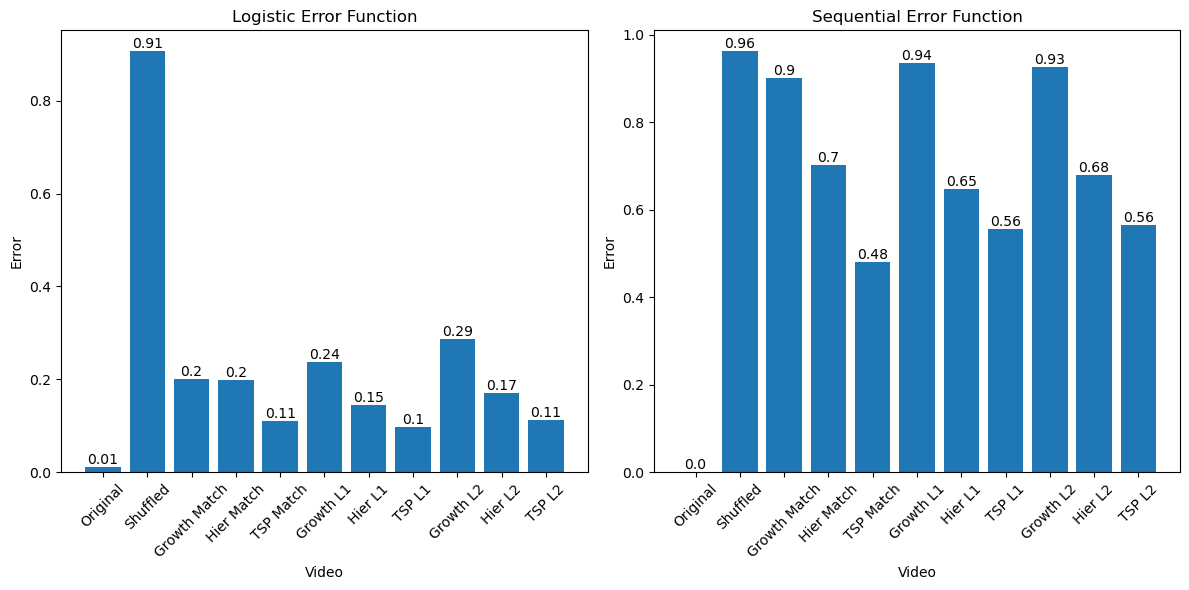

In [25]:
# Define the error values for logistic error function
logistic_errors = [error_orginal, error_shuffled, error_growth_match, error_hier_match, error_tsp_match, error_growth_l1, error_hier_l1, error_tsp_l1, error_growth_l2, error_hier_l2, error_tsp_l2]

# Define the error values for sequential error function
sequential_errors = [sequential_error_orginal, sequential_error_shuffled, sequential_error_growth_match, sequential_error_hier_match, sequential_error_tsp_match, sequential_error_growth_l1, sequential_error_hier_l1, sequential_error_tsp_l1, sequential_error_growth_l2, sequential_error_hier_l2, sequential_error_tsp_l2]

# Define the x-axis labels
labels = ['Original', 'Shuffled', 'Growth Match', 'Hier Match', 'TSP Match', 'Growth L1', 'Hier L1', 'TSP L1', 'Growth L2', 'Hier L2', 'TSP L2']

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the logistic error function
axs[0].bar(labels, logistic_errors)
axs[0].set_xlabel('Video')
axs[0].set_ylabel('Error')
axs[0].set_title('Logistic Error Function')

# Plot the sequential error function
axs[1].bar(labels, sequential_errors)
axs[1].set_xlabel('Video')
axs[1].set_ylabel('Error')
axs[1].set_title('Sequential Error Function')

# Tilt the x-axis labels by 45 degrees
for ax in axs:
    ax.set_xticklabels(labels, rotation=45)

# Add values at the end of each bar for logistic error function
for i, error in enumerate(logistic_errors):
    axs[0].text(i, error, str(round(error, 2)), ha='center', va='bottom')

# Add values at the end of each bar for sequential error function
for i, error in enumerate(sequential_errors):
    axs[1].text(i, error, str(round(error, 2)), ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
